# Programming Exercise Week 9: Toxicity of molecules

## Part A: Preparations

Run the following code to import some tools.

In [2]:
# Pytorch
import torch

# Package for loading the data
import pandas as pd

# Package of functions creating iterators for efficient looping
import itertools 

# Package to (amongst other things) draw and plot molecules in the SMILES format (see below)
!pip install rdkit-pypi -qqq
import rdkit.Chem
import rdkit.Chem.Draw

# Package to shuffle and split the dataset
import sklearn
import sklearn.model_selection

# Plotting
import matplotlib.pyplot as plt

/Users/kiliansprenkamp/miniconda3/envs/refugeeAnalysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

In this exercise we will study the toxicity of molecules.
Molecules will be described using the simplified molecular input line entry system (SMILES). This system allows to describe the structure of chemical species in the form of a line notation, making it suited for a machine learning approach. 

---

**The basic rules for SMILES are:**

* Atom types are represented by their atomic symbols, upper case letters represent aliphatic atoms, lower case letters represented aromatic atoms, hydrogens are often stripped away, since those can be inferred from atom type and connectivity.

* Bonds are only represented if needed:

 $\text{-}$ : single bond (CC and C-C are the same, since single bonds are used by default)

 = : double bond (C=C-C=C and cccc are the same)
 
 $\#$ : triple bond

* Ring opening and closures are represented with numbers: 
 
 c1ccccc1 - benzene

* Substituents leaving a chain or ring are represented with brackets:

 c1cc(C)ccc1 - methyl-substituted benzene.

 CC(F)(Br)Cl - ethane substituted with fluorine, chlorine and bromine

(More detailed rules, not necessary for our exercise, can be found here: https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html)

---

**1a)** With the following commands one can draw a 2d-representation of the molecule using its SMILE representation. Experiment with them to understand how SMILES work.

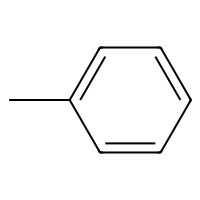

In [3]:
m=rdkit.Chem.MolFromSmiles('c1cc(C)ccc1')
rdkit.Chem.Draw.MolToImage(m, size=(200, 200))

**1b)** With the rules from above, you should be able to create for example the SMILES for acetylsalicylic acid, the active ingredient of Aspirin:
Aspirin-skeletal.svg

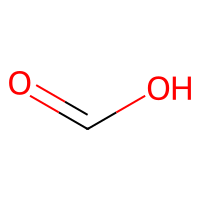

In [4]:
# Write the SMILES for acetylsalicylic acid and check its 2D-representation
m=rdkit.Chem.MolFromSmiles('C(=O)O')
rdkit.Chem.Draw.MolToImage(m, size=(200, 200))

---

**2a)** We now load the toxicity dataset from the TOX21 program (https://github.com/filipsPL/tox21_dataset/tree/master/compounds).

Load the data from the 'sr-are' dataset.

Save the SMILES in the array 'smiles', and the activities in the array 'toxicity'.

In [5]:
import numpy as np
# load the data from the 'sr-are' dataset
datapd = pd.read_csv('https://raw.githubusercontent.com/filipsPL/tox21_dataset/master/compounds/sr-are.tab',sep="\t")
data=datapd.to_numpy()

# define smiles and toxicity
smiles=data[:,1]
toxicity=torch.tensor(np.array(data[:,2],dtype = float))

**2b)** Check the SMILES and toxicity of the first 5 compounds

In [6]:
# print out the SMILES of the first 5 compounds
print(smiles[:5])

['CC(C)=CCC/C(/C)=C/CO' 'OC(=O)CCc1[nH]c2ccccc2[n]1'
 'O=C1Nc2cc(Cl)ccc2N1C1CCN(CCCN2c3ccccc3NC2=O)CC1'
 'Clc1ccccc1-c1[n]c([n]o1)-c1cc[n]cc1'
 'Clc1cc2C(=Nc3ccccc3Oc2cc1)N1CCNCC1']


In [7]:
# print out the activity of the first 5 compounds

print(toxicity[:5])

tensor([0., 0., 0., 1., 0.], dtype=torch.float64)


---

In order to make the data usable for a neural network we have to generate a mapping from characters to integers and vice versa.

We first create a sorted list of the characters used in the SMILES of our dataset, stored in 'unique_chars'. We then create a mapping between this list and the integers.

In [8]:
# list of characters
# itertools.chain makes an iterator that returns elements from the first iterable until it is exhausted, 
# then proceeds to the next iterable, until all of the iterables are exhausted. 
# Consecutive sequences are treated as a single sequence.
unique_chars = list(set(itertools.chain.from_iterable(smiles)))

# Add an end character as the first element in the dictionary
unique_chars.insert(0, 'E')

# character to integer dictionary
# allows fast mapping of a character in smiles to the representative integer
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))

# integer to character dictionary
# allows fast mapping of a representative integer to the smiles character
int_to_char = dict((i, c) for i, c in enumerate(unique_chars))

**3a)** Check that the dictionary is well-defined. Which integer belongs to 'C'?

In [9]:
# print out the dictionary

char_to_int

{'E': 0,
 'C': 1,
 'o': 2,
 '5': 3,
 'K': 4,
 'u': 5,
 '[': 6,
 'F': 7,
 'N': 8,
 '7': 9,
 'l': 10,
 'S': 11,
 '/': 12,
 '=': 13,
 '+': 14,
 '2': 15,
 '#': 16,
 '-': 17,
 'B': 18,
 'i': 19,
 'P': 20,
 '1': 21,
 'M': 22,
 '6': 23,
 ')': 24,
 'H': 25,
 '@': 26,
 '4': 27,
 'r': 28,
 'n': 29,
 'e': 30,
 'Z': 31,
 'O': 32,
 '8': 33,
 'c': 34,
 '(': 35,
 ']': 36,
 '\\': 37,
 'I': 38,
 'g': 39,
 't': 40,
 '9': 41,
 'V': 42,
 's': 43,
 'b': 44,
 '3': 45,
 'A': 46}

In [10]:
# find the integer belonging to 'C'

intC=char_to_int["C"]
print('integer belonging to C: ', intC)

integer belonging to C:  1


**3b)** How many unique characters do we have?

In [11]:
# find the number of unique characters

mapping_size = len(char_to_int)
print ("Size of the character to integer dictionary is: ", mapping_size)

Size of the character to integer dictionary is:  47


---

Now we can encode the SMILES sequences using the dictionary. 

The resulting dimensions of the encoded data array should be (number of SMILES sequences, length of the longest sequence, length of dictionary). 

The last dimension is used as a one-hot-encoding of the respective character. 

For example the indices [11,3,5] correspond to position number 3 of sequence number 11 and to character number 5 in the dictionary: the value in the array is "1" if the character is at this position of the sequence, otherwise "0".

**4a)** First we need the number of SMILES sequences and the length of the longest sequence: 

find and store them in the variables 'n_seq' and 'longest'.

In [12]:
# number of SMILES sequences

n_seq=smiles.shape[0]
print('number of SMILES sequences: ', n_seq)

number of SMILES sequences:  2188


In [13]:
# longest SMILES sequence

longest=max([len(seq)for seq in smiles])
print('length of the longest sequence: ', longest)

length of the longest sequence:  321


The following routine returns the encoded data array, as described above.

In [14]:
# routine to encode the dataset
def gen_data(dataset_of_smiles_seq,char_to_int_dict,number_of_seq,length_of_longest_seq,number_of_unique_chars):
    
    one_hot =  torch.zeros((number_of_seq,length_of_longest_seq,number_of_unique_chars),dtype=torch.float)
    for i,smile in enumerate(dataset_of_smiles_seq):
        #encode the chars
        for j,k in enumerate(smile):
            one_hot[i,j,char_to_int_dict[k]] = 1
    return one_hot

**4b)** Use now this routine with appropriate inputs arrays and variables to encode our SMILES dataset.

In [15]:
# encode the dataset

smiles_enc = gen_data(smiles,char_to_int,n_seq,longest,mapping_size)


**4c)** Check with a couple of random examples that the encoding was done correctly.

In [16]:
# encoding check

sequence_number=2187
character='C'
print(smiles[sequence_number])
print(smiles_enc[sequence_number,:,char_to_int[character]])

CN1[C@@H]2[C@]3(CCN4CC=C[C@](CC)([C@@H]34)[C@@H](OC(C)=O)[C@]2(O)C(=O)OC)c2cc(c(cc12)OC)[C@]1(C[C@@H]2C[C@](O)(CN(C2)CCc2c1[nH]c1ccccc21)CC)C(=O)OC
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

---

## Part B: Machine Learning

We are now ready to apply a machine learning approach to our data: a neural network should learn to recognize the toxicity of a molecule by looking at its SMILE sequence.

We first shuffle the dataset to avoid ordering bias and split it in a train and a test set.

In [17]:
# we shuffle the dataset
X, Y = sklearn.utils.shuffle(smiles_enc, toxicity)

In [18]:
# we split the dataset in a train and a validation set
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(smiles_enc, toxicity, test_size=0.33, random_state=35)

In [19]:
# Dataset class, take a look at exercise class 3
class Data(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index].float(), self.y_data[index].float()
        
    def __len__ (self):
        return len(self.X_data)

# Define batch size
BATCH_SIZE = 32

# Training data
train_data = Data(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# Validation data
val_data = Data(X_val, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)

---

As an example, the following code defines the training and validation functions for a given neural network. You might recongnize the functions from previous exercise sheets. 

In [20]:
def train():
  """This function iterates over the training set once and trains the network with batches of data"""
  # collect correct classifications for accuracy computation
  number_of_correctly_classified_samples = 0
  total_number_of_samples = len(train_data)

  # iterate over all batches of inputs and labels
  for inputs, labels in train_loader:
  
    # forward the data trough the network
    logits = simple_network(inputs).flatten()
    # collect the correct results
    number_of_correctly_classified_samples += sum((logits > 0.5) == labels)

    # compute the loss between the network output and the labels
    J = loss_func(logits, labels)

    # compute the gradients of the loss w.r.t. the learnable parameters
    J.backward()
    # perform a weight update step
    optimizer.step()

    # clear the gradients to start freshly next round
    # DO NOT REMOVE!
    optimizer.zero_grad()

  return number_of_correctly_classified_samples / total_number_of_samples

In [21]:
def validation_accuracy():
  number_of_correctly_classified_samples = 0
  total_number_of_samples = len(val_data)

  # iterate over all batches in the validation set
  for inputs, labels in val_loader:
    # forward the inputs through the network
    logits = simple_network(inputs).flatten()
    # compute how many samples in the batch were correctly classified
    number_of_correctly_classified_samples += sum((logits > 0.5) == labels)
    
  
  # return the accuracy
  return number_of_correctly_classified_samples / total_number_of_samples

---

**5a)** Now define, compile, train and test a neural network having two dense layers with 10 units and lasts 20 epochs.

In [22]:
simple_network = torch.nn.Sequential(
  # We first flatten the two dimensional input 
  torch.nn.Flatten(),
  # first layer (input dim = length_of_longest_seq * number_of_unique_chars, hidden units)
  torch.nn.Linear(longest*mapping_size, 10),
  # activation function
  torch.nn.ReLU(),
  # dropout layer to fight overfitting
  torch.nn.Dropout(p=0.5), 
  # second layer
  torch.nn.Linear(10, 10),
  # activation function
  torch.nn.ReLU(),
  # dropout layer to fight overfitting
  torch.nn.Dropout(p=0.5),    
  # output layer (hidden units, output dim)
  torch.nn.Linear(10,1),
  torch.nn.Sigmoid() 
)

# extract the parameters that we want to optimize
learnable_parameters = simple_network.parameters()

# select an optimizer and pass on these learnable parameters
optimizer = torch.optim.Adam(learnable_parameters)

# select an appropriate loss function
loss_func = torch.nn.BCELoss()

In [23]:
# lists to store the training and validation accuracies
train_accs = []
validation_accs = []

# Number of epochs
epochs = 20

for epoch in range(epochs):
  # train the network
  train_acc = train()
  train_accs.append(train_acc)

  # disable gradient computation during validation
  with torch.no_grad():
    # compute validation accuracy
    val_acc = validation_accuracy()
    validation_accs.append(val_acc)
  # report it
  print(f"Epoch {epoch+1}: accuracy {train_acc:1.4f}")

Epoch 1: accuracy 0.5222
Epoch 2: accuracy 0.5898
Epoch 3: accuracy 0.5891
Epoch 4: accuracy 0.6266
Epoch 5: accuracy 0.6614
Epoch 6: accuracy 0.6655
Epoch 7: accuracy 0.6710
Epoch 8: accuracy 0.6969
Epoch 9: accuracy 0.7038
Epoch 10: accuracy 0.7167
Epoch 11: accuracy 0.7085
Epoch 12: accuracy 0.7270
Epoch 13: accuracy 0.7515
Epoch 14: accuracy 0.7447
Epoch 15: accuracy 0.7570
Epoch 16: accuracy 0.7502
Epoch 17: accuracy 0.8150
Epoch 18: accuracy 0.8423
Epoch 19: accuracy 0.8410
Epoch 20: accuracy 0.8437


The optimisation history can be visualized by plotting the accuracy of the train and of the test set as function of the epochs.

**5b)** Plot the accuracy on training and validation set for each epoch of this neural network. What can be said about the results?

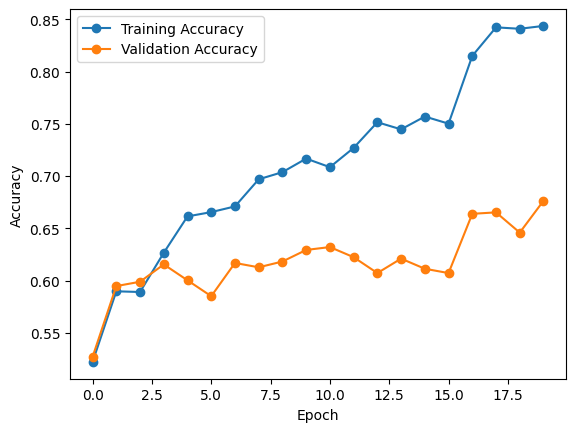

In [24]:
# we plot of the optimisation history
plt.plot(train_accs, '-o', label='Training Accuracy')
plt.plot(validation_accs, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Q: What can be said about these results?

A: The network is clearly overfitting on the training set, as the accuracy on the validation set deviates strongly from that on the training data and does not increase anymore after 3 epochs.

---

We try now to improve the results. In a lot of applications the optimization of the accuracy might be the wrong goal. For example, predicting a non-toxic molecule as toxic is not equally worse than predicting a toxic one as non-toxic. Therefore, we have to consider alternative metrics:

**What are Sensitivity and Specificity?**

* Sensitivity / True Positive Rate (TPR) 

 Sensitivity tells us what proportion of the positive class got correctly classified. A simple example would be to determine what proportion of the actual toxic molecules were correctly detected by the model.

* False Negative Rate (FNR)

 False Negative Rate (FNR) tells us what proportion of the positive class got incorrectly classified by the classifier. A higher TPR and a lower FNR is desirable since we want to correctly classify the positive class.

* Specificity / True Negative Rate (TNR)

 Specificity tells us what proportion of the negative class got correctly classified. Taking the same example as in Sensitivity, Specificity would mean determining the proportion of non-toxic molecules who were correctly identified by the model.

* False Positive Rate (FPR)

 FPR tells us what proportion of the negative class got incorrectly classified by the classifier. A higher TNR and a lower FPR is desirable since we want to correctly classify the non-toxic class.



---

We first calculate the metrics for predictions on the test set.

In [25]:
# we calculate metrics for predictions on validation set
y_pred_logits = simple_network(X_val).flatten().detach()
y_pred = (y_pred_logits > 0.5)

CM = sklearn.metrics.confusion_matrix(y_pred,y_val)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

**6)** Interpret your results. Does this support your findings from above?

**How can we combine these quantities best?**

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the "signal" from the "noise". The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. A random oracle has AUC = 0.5.

**7a)** Use the sklearn functions `sklearn.metrics.roc_curve` and `sklearn.metrics.roc_auc_score` to plot the ROC curve and the area underneath it. Note that you should use `y_pred_logits` as input.

In [26]:
# Compute ROC curve and ROC area for each class

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_val, y_pred_logits, pos_label=1)
roc_auc = sklearn.metrics.roc_auc_score(y_val,y_pred_logits)

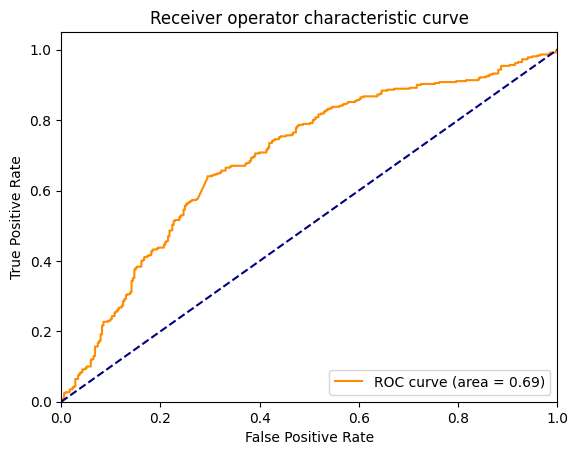

In [27]:
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operator characteristic curve")
plt.legend(loc="lower right")
plt.show()

**7b)** Interpret your results. What is an advantage of the AUC score? What could be a disadvantage?

---

The neural network used above does not seem to perform well. We try an approach with a Long Short-Term Memory network (LSTM).

**8)** Play around with the parameters of the LSTM model and try to improve the performance.

In [29]:
from torch import nn
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[:, -1, :]

In [48]:
LSTMClassifier = torch.nn.Sequential(
  
  # We first flatten the two dimensional input 
  torch.nn.Flatten(),
  
  torch.nn.LSTM(longest*mapping_size, 10, 1, batch_first=True),
  extract_tensor(),
  # first layer (input dim = length_of_longest_seq * number_of_unique_chars, hidden units)
  torch.nn.Linear(10, 10),
  
  # activation function
  torch.nn.ReLU(),
  # dropout layer to fight overfitting
  torch.nn.Dropout(p=0.5), 
  # second layer
  torch.nn.Linear(10, 10),
  # activation function
  torch.nn.ReLU(),
  # dropout layer to fight overfitting
  torch.nn.Dropout(p=0.5),    
  # output layer (hidden units, output dim)
  torch.nn.Linear(10,1),
  torch.nn.Sigmoid() 
)

# extract the parameters that we want to optimize
learnable_parameters = simple_network.parameters()

# select an optimizer and pass on these learnable parameters
optimizer = torch.optim.Adam(learnable_parameters)

# select an appropriate loss function
loss_func = torch.nn.BCELoss()

In [31]:
# LSTM model
class LSTMClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_size, label_size, dropout_rate):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_size) # Output layer
        self.activation = torch.nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out = torch.nn.Linear(hidden_size, label_size) # Output layer
        self.dropout = torch.nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out


In [32]:

class MockupModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(
                input_size=x_features,    # 45, see the data definition
                hidden_size=hidden_size,  # Can vary
            ),
            'linear': nn.Linear(
                in_features=hidden_size,
                out_features=1)
        })
    
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        print(f'lstm output={out.size()}')

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
        print(f'transformed output={out.size()}')

        # Data is fed to the Linear layer
        out = self.model['linear'](out)
        print(f'linear output={out.size()}')

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
        print(f'y_pred={y_pred.size()}')

        return y_pred

In [46]:
lstm_network = LSTMClassifier()

# extract the parameters that we want to optimize
learnable_parameters = lstm_network.parameters()

# select an optimizer and pass on these learnable parameters
#optimizer = torch.optim.Adam(learnable_parameters)
optimizer = torch.optim.Adam(learnable_parameters, lr=0.003)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, 
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

# select an appropriate loss function
loss_func = torch.nn.BCEWithLogitsLoss()

TypeError: forward() missing 1 required positional argument: 'input'

In [47]:
for inputs, labels in train_loader:
    print(inputs.shape)
    print(labels.shape)

torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size([32, 321, 47])
torch.Size([32])
torch.Size(

In [49]:
def train():
  """This function iterates over the training set once and trains the network with batches of data"""
  # collect correct classifications for accuracy computation
  number_of_correctly_classified_samples = 0
  total_number_of_samples = len(train_data)

  # iterate over all batches of inputs and labels
  for inputs, labels in train_loader:
  
    # forward the data trough the network
    logits = lstm_network(inputs).flatten()
    # collect the correct results
    logits
    number_of_correctly_classified_samples += sum((logits > 0.5) == labels)

    # compute the loss between the network output and the labels
    J = loss_func(logits, labels)

    # compute the gradients of the loss w.r.t. the learnable parameters
    J.backward()

    torch.nn.utils.clip_grad_norm_(lstm_network.parameters(), 1)

    # perform a weight update step
    optimizer.step()

    # clear the gradients to start freshly next round
    # DO NOT REMOVE!
    optimizer.zero_grad()

  return number_of_correctly_classified_samples / total_number_of_samples

In [50]:
def validation_accuracy():
  number_of_correctly_classified_samples = 0
  total_number_of_samples = len(val_data)

  # iterate over all batches in the validation set
  for inputs, labels in val_loader:
    # forward the inputs through the network
    logits = lstm_network(inputs).flatten()
    # compute how many samples in the batch were correctly classified
    number_of_correctly_classified_samples += sum((logits > 0.5) == labels)
    
  
  # return the accuracy
  return number_of_correctly_classified_samples / total_number_of_samples

In [51]:
# lists to store the training and validation accuracies
train_accs = []
validation_accs = []

# Number of epochs
epochs = 5

for epoch in range(epochs):
  # train the network
  train_acc = train()
  train_accs.append(train_acc)

  # disable gradient computation during validation
  with torch.no_grad():
    # compute validation accuracy
    val_acc = validation_accuracy()
    validation_accs.append(val_acc)
  # report it
  print(f"Epoch {epoch+1}: accuracy {train_acc:1.4f}")

RuntimeError: all elements of input should be between 0 and 1

**6b)** Plot the optimisation history of this neural network. Are the results better?

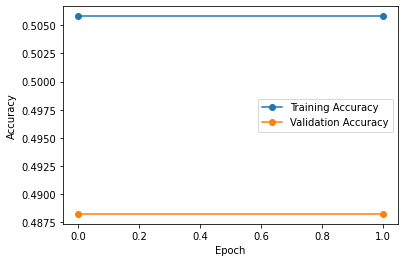

In [92]:
# we plot of the optimisation history
plt.plot(train_accs, '-o', label='Training Accuracy')
plt.plot(validation_accs, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()